<i>STATUS: Draft<i>

In [1]:
import numpy as np
import sympy as sp
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Rectangle
from IPython.display import Image
import sys


In the last notebook, we finished getting a basic handle on SDRs. We are now ready to start using htm.core a little, and also I will take the opportunity to clean up functions that I have created. 

We have some funtions that are to create SDRs, create noise. Let's first group the functions, to clean up mostly around making the visualisation, to pass SDRs of any size and getting coordinates. From here will start to build out a code base but also show along the way how we can use something more sophisticated. It seems a right of passage in HTM to build your own implementation, so we will use code for that, but htm.core will be what you want for production.

I will also start to look at various functions in the htm.core so we can use similiar types of language as we build things. 

Everything here is quite similiar, I made the visualise function more general so it can take SDRs of different sizes and also can be used for encoders

In [2]:
#################### SINGLE SDR FUNCTIONS ###################################################


def create_randomised_sdr(capacity, population):
    sdr = set()
    while len(sdr) < population:
        sdr.add(np.random.randint(low=1, high=capacity))

    return(list(sdr))


def randomly_flip_percentage_of_bits(SDR, array_size, percentage_to_flip):
    to_remove = int(percentage_to_flip * len(SDR))
    randomised_SDR = np.random.shuffle(SDR)
    del SDR[0:to_remove]
    noise = create_randominsed_sdr(np.sqrt(array_size), np.sqrt(array_size), to_remove)
    sdr_with_noise = noise + SDR
    return(sdr_with_noise)



############## MULTIPLE SDR FUNCTIONS ###################################################
def compute_union_and_overlap(SDR1_on_bits, SDR2_on_bits):
    union = list(set(SDR1_on_bits).union(SDR2_on_bits))
    overlap = list(set(SDR1_on_bits).intersection(SDR2_on_bits))
    
    return({"union": union, "overlap": overlap})

def create_and_compare_sdrs_over_multiple_iterations(iterations, sdr_size, population):
    sdr_unions_for_comparison = []
    sdr_overlaps_for_comparison = []
    for x in range(iterations):
        SDR1 = create_randominsed_sdr(sdr_size, population)
        SDR2 =create_randominsed_sdr(sdr_size, population)
        sdr_comparison = compute_union_and_overlap(SDR1, SDR2)
        sdr_unions_for_comparison.append(len(sdr_comparison['union']))
        sdr_overlaps_for_comparison.append(len(sdr_comparison['overlap']))
    print("Average union: ", str(sum(sdr_unions_for_comparison) / len(sdr_unions_for_comparison)))
    print("Average overlap: ", str(sum(sdr_overlaps_for_comparison) / len(sdr_overlaps_for_comparison)))
    return({"union_comparison": sdr_unions_for_comparison, "overlap_comparison": sdr_overlaps_for_comparison})

def compute_overlap_set_cardinality(n, w0, w1, b, provide_summary = True):
    on_bit_space = sp.binomial(w0, b)
    off_bit_space = sp.binomial(n - w0, w1 - b)
    overlap_set = on_bit_space * off_bit_space
    if provide_summary:
        print("Given a capcity of", str(w0), "bits in the on-bit space, the number of ways to arrange ", str(b), "on-bits: ", on_bit_space)
        print("Given a capacity", str(n - w0), "bits in the off-bit space, the number of ways to arrange", str(w1 - b), "off-bits: ", off_bit_space)
        print("Number of SDRs that will match w0: ", overlap_set)
    return(overlap_set)

######################## VISUALISATION FUNCTIONS ############################################


def create_axis_for_sdr(ax, x_limit, y_limit, population, label, create_label = True):
    
    if create_label:
        label_add = np.round((population / (x_limit * y_limit)) * 100, 2)
        label = label + ' (Sparsity: {}%)'.format(label_add)
        ax.set_xlabel(label)
        
    ax.set_xticks(range(int(x_limit)))
    ax.set_yticks(range(int(y_limit)))
    [ax.xaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(x_limit))]
    [ax.yaxis.get_major_ticks()[i].tick1line.set_color("white") for i in range(int(y_limit))]
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.grid(color='k', linestyle='-', linewidth=.5)
    
    return(ax)


def convert_sdr_to_tuple_for_visualisation(sdr, sdr_size):
    
    counting_offset = 1
    # create array of complete sdrs

    m = np.zeros(sdr_size)
    for i in sdr:
        m[i] = m[i] + 1
    
    # find dimensions of visualisation
    n = sp.symbols('n')
    e = sp.Eq(2**n, sdr_size)
    s = sp.solve(e, n)
    middle_index = np.floor(float(s[0] / 2))
    
    if s[0] % 2 == 0:
        dimensions = [2**middle_index, 2**middle_index]
    else:
        dimensions = [2**middle_index, 2**(middle_index + 1)]
    
    d = np.reshape(m, [int(v) for v in dimensions])
    
    v = np.where(d == 1)

    
    coords = [(v[1][i], (dimensions[1] - counting_offset) - v[0][i]) for i in range(len(v[1]))]
    

    
    return(coords)


Let's test our code so far a little: 

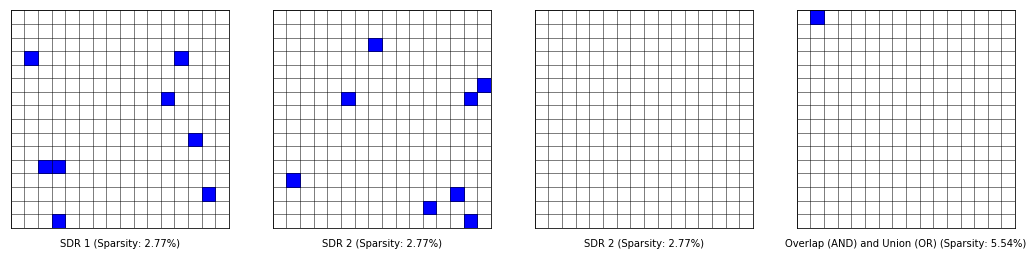

In [4]:
sdr_size = 256
population = 8
#label = str(np.round(sdr_size/population, 3))

specs1 = create_randomised_sdr(sdr_size, population)
specs2 = create_randomised_sdr(sdr_size, population)

x_vals, y_vals = sdr_comparison = compute_union_and_overlap(specs1, specs2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 4))

ax1 = create_axis_for_sdr(ax1, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 1")
ax2 = create_axis_for_sdr(ax2, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax3 = create_axis_for_sdr(ax3, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, population, "SDR 2")
ax4 = create_axis_for_sdr(ax4, np.sqrt(sdr_size) + 1, np.sqrt(sdr_size) + 1, len(sdr_comparison['union']), "Overlap (AND) and Union (OR)")


SDR1 = [ax1.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs1, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs1))]
SDR2 = [ax2.add_patch(Rectangle(convert_sdr_to_tuple_for_visualisation(specs2, sdr_size)[i], 1, 1, color="blue")) for i in range(len(specs2))]
SDR3 = ax4.add_patch(Rectangle([1,15], 1, 1, color="blue"))
#union = [ax3.add_patch(Rectangle(sdr_comparison['union'][i], 1, 1, color="gray")) for i in range(len(sdr_comparison['union']))]
# overlap = [ax3.add_patch(Rectangle(sdr_comparison['overlap'][i], 1, 1, color="orange")) for i in range(len(sdr_comparison['overlap']))]


Looks like things still work. Now let's move on to the idea of an encoder. THer is a videa for this which is very handy, we know that SDRs are a powerful way to get data, but how do take data that we experience in the real world and put it into this format. Start with the HTM shcool video: 

In [5]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/V3Yqtpytif0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

At this point to we are going to start uisng the BAMI resource found at: [HERE]

1. Semantically similar data should result in SDRs with overlapping active bits.

2. The same input should always produce the same SDR as output.

3. The output should have the same dimensionality (total number of bits) for all inputs.

4. The output should have similar sparsity for all inputs and have enough one-bits to handle noise and
    subsampling.
    


Let's build an encorder and start with numbers, numbers are bit overly simple. For an input space a grid like above, how many buckets can 


In [6]:
def compute_bucket_capacity(n, w):
    bucket_capacity = n - w + 1
    
    return(bucket_capacity)

An intuitive way to think about this is is 400 bits in my outputs space. If i have a bucket size of 1 how many bits can this encode? If I wanted each integer represetned

In [7]:
compute_bucket_capacity(400, 1)

400

To get a sense of an ecoder, let's build it as a Python class. Its kind of an object type of thing, so let's treat it that way. This enoder will set up the size of the bit space, know how many buckets, and provide values back. 

In [20]:
class CreateEncoder:
    def __init__(self, bit_space_size = None,
                number_of_bits_per_value = None,
                min_val = None,
                max_val = None):
        self.bit_space_size = bit_space_size
        self.number_of_bits_per_value = number_of_bits_per_value
        self.min_value_to_encode = min_val
        self.max_value_to_encode = max_val
        self.buckets = self.compute_bucket_capacity(self.bit_space_size, self.number_of_bits_per_value)
        self.offset = 1
        self.current_encoded_value = None
        self.bit_locations_for_current_encoded_value = None
        self.previously_encoded_values = np.array([])
        self.is_periodic = False
        
    def get_summary(self):
        print("#### SUMMARY ######")
        print("Bit Space Size: ", self.bit_space_size)
        print("Number of bits used to encode each value:", self.number_of_bits_per_value)
        print("Number of buckets available in bit space:", self.buckets)
        print("Range of values to be encoded: ", self.min_value_to_encode, ' - ', self.max_value_to_encode)
        print("Current encoded value: ", self.current_encoded_value)
        print("Bit locations for current encoded value: ", self.bit_locations_for_current_encoded_value)
        print("Previously encoded values: ", self.previously_encoded_values)
        print("Encode periodically: ", self.is_periodic)
    
    def compute_bucket_capacity(self, n, w):
        return(n - w + 1)

    
    def encode_value_in_bit_space(self, value_choice):
        if self.current_encoded_value is not None:
            self.previously_encoded_values = np.append(self.previously_encoded_values, self.current_encoded_value)
        
        self.current_encoded_value = value_choice
        window = [self.current_encoded_value , self.current_encoded_value + self.number_of_bits_per_value - self.offset ]
        all_values = np.arange(window[0], window[1] + self.offset)
        self.bit_locations_for_current_encoded_value = all_values
    
    def update_bit_space_size(self, n):
        pass
    
    
        
        


So my encoder has a bunch of functions, let's create an instance of it with some initial parameters and see what it can do:

In [22]:
b_size = 256
population = 5
min_value_to_encode = 0
max_value_to_encode = 100

encoder1 = CreateEncoder(bit_space_size = b_size,
                number_of_bits_per_value = population,
                min_val = min_value_to_encode,
                max_val = max_value_to_encode)

encoder1.get_summary()

#### SUMMARY ######
Bit Space Size:  256
Number of bits used to encode each value: 5
Number of buckets available in bit space: 252
Range of values to be encoded:  0  -  100
Current encoded value:  None
Bit locations for current encoded value:  None
Previously encoded values:  []
Encode periodically:  False


Let's create an encoded value and run the summary again: 

In [14]:
encoder1.bit_space_size = 1024

In [15]:
encoder1.encode_value_in_bit_space(value_choice=3)
encoder1.get_summary()

#### SUMMARY ######
Bit Space Size:  1024
Number of bits used to encode each value: 13
Number of buckets available in bit space: 244
Range of values to be encoded:  0  -  100
Current encoded value:  3
Bit locations for current encoded value:  [ 3  4  5  6  7  8  9 10 11 12 13 14 15]
Previously encoded values:  [3. 3.]
Encode periodically:  False


And now, let's add another value, this time 17. We can see the summary has updated: 

In [16]:
encoder1.encode_value_in_bit_space(value_choice=3)
encoder1.get_summary()

#### SUMMARY ######
Bit Space Size:  1024
Number of bits used to encode each value: 13
Number of buckets available in bit space: 244
Range of values to be encoded:  0  -  100
Current encoded value:  3
Bit locations for current encoded value:  [ 3  4  5  6  7  8  9 10 11 12 13 14 15]
Previously encoded values:  [3. 3. 3.]
Encode periodically:  False


We didn't include the on-bits that would be created as this would make the summary a bit long, but access them through the class attributes

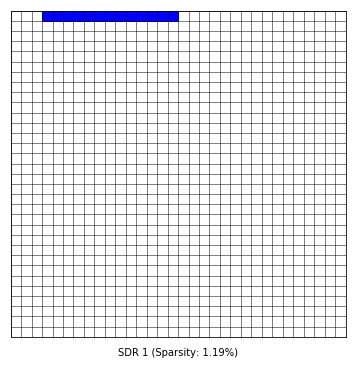

In [18]:

b_size = 1024
fig, (ax1) = plt.subplots(1, 1, figsize=(6, 6))

ax1 = create_axis_for_sdr(ax1, np.sqrt(b_size) + 1, np.sqrt(b_size) + 1, population, "SDR 1")
coords = convert_sdr_to_tuple_for_visualisation(encoder1.bit_locations_for_current_encoded_value, b_size)


SDR1 = [ax1.add_patch(Rectangle(coords[i], 1, 1, color="blue")) for i in range(len(t))]


In [ ]:
f.get_location_of_value(22)

In [ ]:
f.previously_encoded_values